In [1]:
%load_ext autoreload
%autoreload 2

import torch

from text3d2video.artifacts.animation_artifact import AnimationArtifact

torch.set_grad_enabled(False)

animation = AnimationArtifact.from_wandb_artifact_tag("backflip:latest")
n_frames = 6
frame_nums = animation.frame_nums(n_frames)
frames = animation.load_frames(frame_nums)
cameras = animation.cameras(frame_nums)

/home/jorge/miniconda3/envs/thesis4/lib/python3.9/site-packages/pytorch3d/io/obj_io.py:546: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


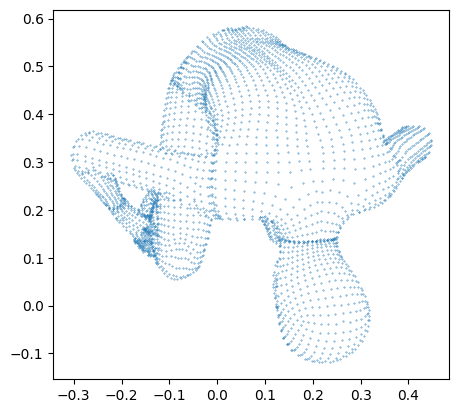

In [2]:
from matplotlib import pyplot as plt

from text3d2video.util import project_vertices_to_cameras

visible_vert_coords, visible_vert_indices = project_vertices_to_cameras(frames, cameras)

n_verts = frames.num_verts_per_mesh()[0]

for indices in visible_vert_indices:
    assert indices.min() >= 0
    assert indices.max() < n_verts

frame_visible_vert_coords = visible_vert_coords[3].cpu()
plt.scatter(frame_visible_vert_coords[:, 0], frame_visible_vert_coords[:, 1], s=0.1)
plt.gca().set_aspect("equal")

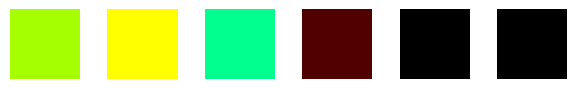

In [31]:
from text3d2video.ipython_utils import display_ims
from visual_tests.testing_utils import random_color, test_img
import torchvision.transforms.functional as TF

images = [test_img(resolution=100, color=random_color()) for i in range(n_frames)]
feature_maps = torch.stack([TF.to_tensor(img) for img in images])

display_ims(images)

aggregating: 0.008949345909059048
rendering: 0.040637144120410085


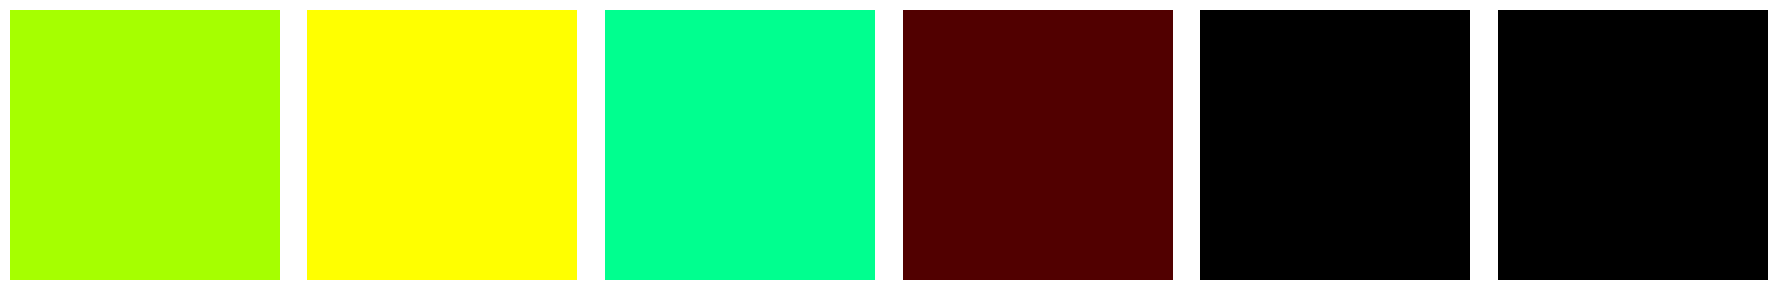

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


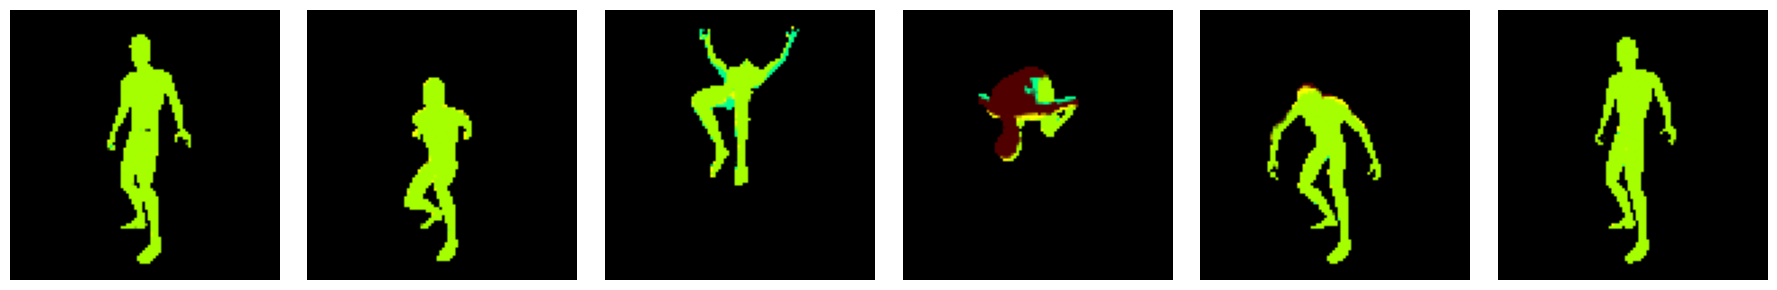

In [32]:
from codetiming import Timer
from text3d2video.ipython_utils import display_ims
import torchvision.transforms.functional as TF

from text3d2video.rendering import make_feature_renderer
from text3d2video.util import (
    aggregate_features_precomputed_vertex_positions,
)
from pytorch3d.renderer import TexturesVertex

h = 100
d = 3

with Timer(text="aggregating: {}"):
    vert_features = aggregate_features_precomputed_vertex_positions(
        feature_maps,
        frames.num_verts_per_mesh()[0],
        visible_vert_coords,
        visible_vert_indices,
        aggregation_type="first",
    )

with Timer(text="rendering: {}"):
    renderer = make_feature_renderer(cameras[0], h)
    tex = TexturesVertex(vert_features.expand(n_frames, -1, -1))
    frames.textures = tex
    feature_images = renderer(frames)

display_ims([TF.to_pil_image(map) for map in feature_maps], scale=3)
display_ims([img for img in feature_images.cpu()], scale=3)

torch.cuda.empty_cache()

In [39]:
data = torch.zeros(10)

indices = torch.Tensor([0, 1, 2, 3]).long()
values = torch.ones(len(indices))
data[indices] = values

indices = torch.Tensor([2, 3, 4, 5]).long()
values = torch.ones(len(indices)) * 3

mask = data[indices] == 0
data[indices[mask]] = values[mask]

data

tensor([1., 1., 1., 1., 3., 3., 0., 0., 0., 0.])